In [1]:
import numpy as np
import pandas as pd
import random
import time
import matplotlib.pyplot as plt
from IPython import display

from FCLayer import FCLayer
from ActivationLayer import ActivationLayer
from Activations import *
from losses import mse, mse_prime
from Accuracy import *

In [2]:
class LoadPreprocessData:
    def __init__(self, path, header = None):
        self.dataset = pd.read_csv(path, header = header)
        self.X = self.dataset.iloc[:, :-1]
        self.y = self.dataset.iloc[:, -1]
        
    def normalize(self, axis = 0):
        self.X = ((self.X - self.X.mean(axis = axis)) / self.X.std(axis = axis))
    
    def train_test_split(self, percent = 80):
        train_rows = random.sample(range(0, self.y.size), percent * self.y.size // 100)
        train_rows.sort()
        test_rows=[rows for rows in self.X.index.values if rows not in train_rows]
        self.train_X = self.X.iloc[train_rows].reset_index(drop = True)
        self.train_y = self.y.iloc[train_rows].reset_index(drop = True) 
        
        self.test_X = self.X.iloc[test_rows].reset_index(drop = True) 
        self.test_y = self.y.iloc[test_rows].reset_index(drop = True) 

In [3]:
dataClass = LoadPreprocessData("housepricedata.csv", 0)
dataClass.normalize()
dataClass.train_test_split()

In [4]:
dataClass.train_X

LotArea  OverallQual  OverallCond  TotalBsmtSF  FullBath  HalfBath  \
0    -0.207071     0.651256    -0.517023    -0.459145  0.789470  1.227165   
1    -0.091855    -0.071812     2.178881     0.466305  0.789470 -0.761360   
2     0.073455     0.651256    -0.517023    -0.313261  0.789470  1.227165   
3    -0.096864     0.651256    -0.517023    -0.687089 -1.025689 -0.761360   
4     0.375020     1.374324    -0.517023     0.199611  0.789470  1.227165   
...        ...          ...          ...          ...       ...       ...   
1163 -0.685467    -0.794879    -0.517023    -1.163490 -1.025689 -0.761360   
1164 -0.302249     0.651256    -0.517023     0.372848  0.789470 -0.761360   
1165 -0.260471    -0.071812    -0.517023    -0.238040  0.789470  1.227165   
1166  0.266316    -0.071812     0.381612     1.104547  0.789470 -0.761360   
1167 -0.147760     0.651256     3.077516     0.215567  0.789470 -0.761360   

      BedroomAbvGr  TotRmsAbvGrd  Fireplaces  GarageArea  
0         0.163723      0.911897   -0.950901    0.350880  
1         0.163723     -0.318574    0.600289   -0.060710  
2         0.163723     -0.318574    0.600289    0.631510  
3         0.163723      0.296662    0.600289    0.790533  
4         1.389547      1.527133    0.600289    1.697903  
...            ...           ...         ...         ...  
1163     -1.062101     -0.933810   -0.950901    0.243305  
1164     -1.062101     -0.318574   -0.950901   -0.341340  
1165      0.163723      0.296662    0.600289   -0.060710  
1166      0.163723      0.296662    2.151479    0.126376  
1167      1.389547      1.527133    2.151479   -1.033560  

[1168 rows x 10 columns]

In [5]:
class Network:
    def __init__(self):
        self.layers = []
        self.loss = None
        self.loss_prime = None

    # add layer to network
    def add(self, layer):
        self.layers.append(layer)

    # set loss to use
    def use(self, loss, loss_prime):
        self.loss = loss
        self.loss_prime = loss_prime

    # predict output for given input
    def predict(self, input_data):
        # sample dimension first
        samples = len(input_data)
        result = []

        # run network over all samples
        for i in range(samples):
            # forward propagation
            output = input_data[i]
            for layer in self.layers:
                output = layer.forward_propagation(output)
            result.append(output)

        return result

    # train the network
    def fit(self, x_train, y_train, epochs, learning_rate, plot = True):
        
        # plot parameters
        losses = []
        x = []
        # sample dimension first
        samples = len(x_train)

        # training loop
        for i in range(epochs):
            err = 0
            for j in range(samples):
                # forward propagation
                output = x_train[j]
                for layer in self.layers:
                    output = layer.forward_propagation(output)

                # compute loss (for display purpose only)
                err += self.loss(y_train[j], output)
                
                # backward propagation
                error = self.loss_prime(y_train[j], output)
                for layer in reversed(self.layers):
                    error = layer.backward_propagation(error, learning_rate)

            # calculate average error on all samples
            err /= samples
            losses = np.append(losses, err)
            x = np.append(x, i)        
            if i % 100 == 0:
                print('epoch %d/%d   error=%f' % (i+1, epochs, err))
                if plot:
                    plt.gca().cla() 
                    plt.plot(x, losses,label='test')
                    plt.legend()
                    display.display(plt.gcf()) 
                    time.sleep(0.1) 
                    display.clear_output(wait=True)

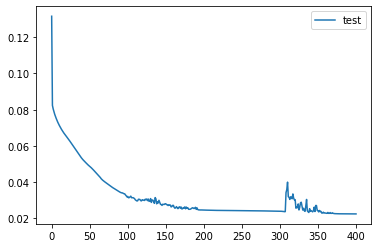

In [122]:
# network

# weights initialization
weights = "normal"

net = Network()
net.add(FCLayer(10, 20, weights))
net.add(ActivationLayer(sigmoid, sigmoid_prime))
net.add(FCLayer(20,10, weights))
net.add(ActivationLayer(sigmoid, sigmoid_prime))
net.add(FCLayer(10,1, weights))
net.add(ActivationLayer(sigmoid, sigmoid_prime))
# train
net.use(mse, mse_prime)
net.fit(dataClass.train_X.values.reshape(1168,1,10), dataClass.train_y.values.reshape(1168,1,1), epochs=500, learning_rate=0.2)

# test
# out = net.predict(x_train)
# print(out)

In [123]:
predicted = net.predict(dataClass.test_X.values.reshape(292,1,10))
predicted = [0 if x < 0.5 else 1 for x in predicted]
predicted;
actual = dataClass.test_y;

In [124]:
np.count_nonzero(np.array(predicted) == dataClass.test_y)/292

0.9075342465753424

In [125]:
accuracy = Accuracy(predicted, actual)
accuracy.accuracy()

0.9075342465753424

In [126]:
accuracy.F_score()
accuracy.fScore

0.9084745762711864

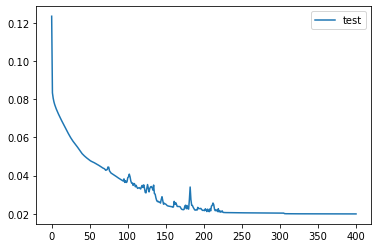

In [6]:
# network

# weights initialization
weights = "normal"

net = Network()
net.add(FCLayer(10, 20, weights))
net.add(ActivationLayer(sigmoid, sigmoid_prime))
net.add(FCLayer(20,10, weights))
net.add(ActivationLayer(sigmoid, sigmoid_prime))
net.add(FCLayer(10,1, weights))
net.add(ActivationLayer(sigmoid, sigmoid_prime))
# train
net.use(mse, mse_prime)
net.fit(dataClass.train_X.values.reshape(1168,1,10), dataClass.train_y.values.reshape(1168,1,1), epochs=500, learning_rate=0.3)

# test
# out = net.predict(x_train)
# print(out)

In [7]:
predicted = net.predict(dataClass.test_X.values.reshape(292,1,10))
predicted = [0 if x < 0.5 else 1 for x in predicted]
predicted;
actual = dataClass.test_y;

In [8]:
np.count_nonzero(np.array(predicted) == dataClass.test_y)/292

0.9075342465753424

In [9]:
accuracy = Accuracy(predicted, actual)
accuracy.accuracy()

0.9075342465753424

In [10]:
accuracy.F_score()
accuracy.fScore

0.9052631578947368

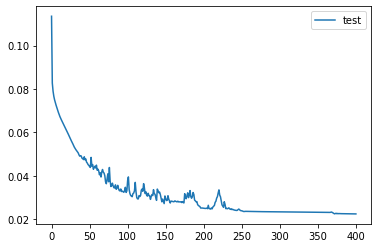

In [66]:
# network

# weights initialization
weights = "normal"

net = Network()
net.add(FCLayer(10, 20, weights))
net.add(ActivationLayer(sigmoid, sigmoid_prime))
net.add(FCLayer(20,10, weights))
net.add(ActivationLayer(sigmoid, sigmoid_prime))
net.add(FCLayer(10,1, weights))
net.add(ActivationLayer(sigmoid, sigmoid_prime))
# train
net.use(mse, mse_prime)
net.fit(dataClass.train_X.values.reshape(1168,1,10), dataClass.train_y.values.reshape(1168,1,1), epochs=500, learning_rate=0.4)

# test
# out = net.predict(x_train)
# print(out)

In [67]:
predicted = net.predict(dataClass.test_X.values.reshape(292,1,10))
predicted = [0 if x < 0.5 else 1 for x in predicted]
predicted;
actual = dataClass.test_y;

In [68]:
np.count_nonzero(np.array(predicted) == dataClass.test_y)/292

0.9075342465753424

In [69]:
accuracy = Accuracy(predicted, actual)
accuracy.accuracy()

0.9075342465753424

In [70]:
accuracy.F_score()
accuracy.fScore

0.9059233449477352

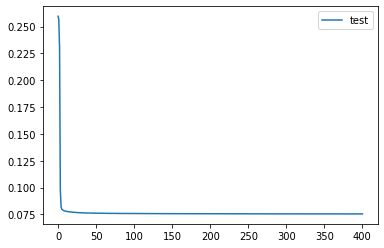

In [127]:
# network

# weights initialization
weights = "0"

net = Network()
net.add(FCLayer(10, 20, weights))
net.add(ActivationLayer(sigmoid, sigmoid_prime))
net.add(FCLayer(20,10, weights))
net.add(ActivationLayer(sigmoid, sigmoid_prime))
net.add(FCLayer(10,1, weights))
net.add(ActivationLayer(sigmoid, sigmoid_prime))
# train
net.use(mse, mse_prime)
net.fit(dataClass.train_X.values.reshape(1168,1,10), dataClass.train_y.values.reshape(1168,1,1), epochs=500, learning_rate=0.2)

# test
# out = net.predict(x_train)
# print(out)

In [128]:
predicted = net.predict(dataClass.test_X.values.reshape(292,1,10))
predicted = [0 if x < 0.5 else 1 for x in predicted]
predicted;
actual = dataClass.test_y;

In [129]:
np.count_nonzero(np.array(predicted) == dataClass.test_y)/292

0.9246575342465754

In [130]:
accuracy = Accuracy(predicted, actual)
accuracy.accuracy()

0.9246575342465754

In [131]:
accuracy.F_score()
accuracy.fScore

0.9241379310344827

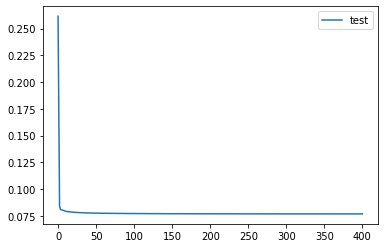

In [11]:
# network

# weights initialization
weights = "0"

net = Network()
net.add(FCLayer(10, 20, weights))
net.add(ActivationLayer(sigmoid, sigmoid_prime))
net.add(FCLayer(20,10, weights))
net.add(ActivationLayer(sigmoid, sigmoid_prime))
net.add(FCLayer(10,1, weights))
net.add(ActivationLayer(sigmoid, sigmoid_prime))
# train
net.use(mse, mse_prime)
net.fit(dataClass.train_X.values.reshape(1168,1,10), dataClass.train_y.values.reshape(1168,1,1), epochs=500, learning_rate=0.3)

# test
# out = net.predict(x_train)
# print(out)

In [12]:
predicted = net.predict(dataClass.test_X.values.reshape(292,1,10))
predicted = [0 if x < 0.5 else 1 for x in predicted]
predicted;
actual = dataClass.test_y;

In [13]:
np.count_nonzero(np.array(predicted) == dataClass.test_y)/292

0.9246575342465754

In [14]:
accuracy = Accuracy(predicted, actual)
accuracy.accuracy()

0.9246575342465754

In [15]:
accuracy.F_score()
accuracy.fScore

0.9241379310344827

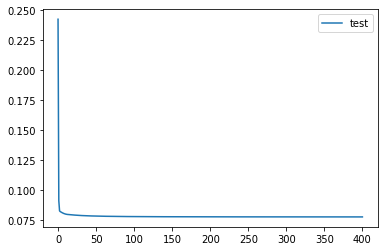

In [71]:
# network

# weights initialization
weights = "0"

net = Network()
net.add(FCLayer(10, 20, weights))
net.add(ActivationLayer(sigmoid, sigmoid_prime))
net.add(FCLayer(20,10, weights))
net.add(ActivationLayer(sigmoid, sigmoid_prime))
net.add(FCLayer(10,1, weights))
net.add(ActivationLayer(sigmoid, sigmoid_prime))
# train
net.use(mse, mse_prime)
net.fit(dataClass.train_X.values.reshape(1168,1,10), dataClass.train_y.values.reshape(1168,1,1), epochs=500, learning_rate=0.4)

# test
# out = net.predict(x_train)
# print(out)

In [72]:
predicted = net.predict(dataClass.test_X.values.reshape(292,1,10))
predicted = [0 if x < 0.5 else 1 for x in predicted]
predicted;
actual = dataClass.test_y;

In [73]:
np.count_nonzero(np.array(predicted) == dataClass.test_y)/292

0.9246575342465754

In [74]:
accuracy = Accuracy(predicted, actual)
accuracy.accuracy()

0.9246575342465754

In [75]:
accuracy.F_score()
accuracy.fScore

0.9241379310344827

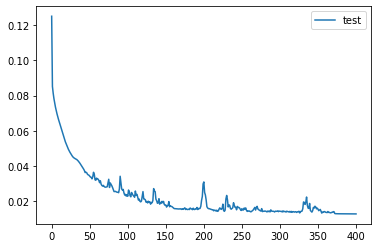

In [87]:
# network

# weights initialization
weights = "gaussian"

net = Network()
net.add(FCLayer(10, 20, weights))
net.add(ActivationLayer(sigmoid, sigmoid_prime))
net.add(FCLayer(20,10, weights))
net.add(ActivationLayer(sigmoid, sigmoid_prime))
net.add(FCLayer(10,1, weights))
net.add(ActivationLayer(sigmoid, sigmoid_prime))
# train
net.use(mse, mse_prime)
net.fit(dataClass.train_X.values.reshape(1168,1,10), dataClass.train_y.values.reshape(1168,1,1), epochs=500, learning_rate=0.3)

# test
# out = net.predict(x_train)
# print(out)

In [88]:
predicted = net.predict(dataClass.test_X.values.reshape(292,1,10))
predicted = [0 if x < 0.5 else 1 for x in predicted]
predicted;
actual = dataClass.test_y;

In [89]:
np.count_nonzero(np.array(predicted) == dataClass.test_y)/292

0.8527397260273972

In [90]:
accuracy = Accuracy(predicted, actual)
accuracy.accuracy()

0.8527397260273972

In [91]:
accuracy.F_score()
accuracy.fScore

0.8522336769759451

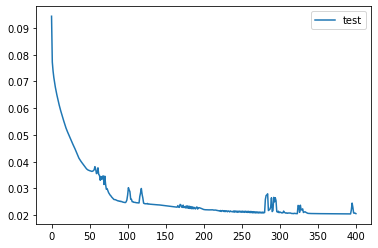

In [132]:
# network

# weights initialization
weights = "gaussian"

net = Network()
net.add(FCLayer(10, 20, weights))
net.add(ActivationLayer(sigmoid, sigmoid_prime))
net.add(FCLayer(20,10, weights))
net.add(ActivationLayer(sigmoid, sigmoid_prime))
net.add(FCLayer(10,1, weights))
net.add(ActivationLayer(sigmoid, sigmoid_prime))
# train
net.use(mse, mse_prime)
net.fit(dataClass.train_X.values.reshape(1168,1,10), dataClass.train_y.values.reshape(1168,1,1), epochs=500, learning_rate=0.2)

# test
# out = net.predict(x_train)
# print(out)

In [133]:
predicted = net.predict(dataClass.test_X.values.reshape(292,1,10))
predicted = [0 if x < 0.5 else 1 for x in predicted]
predicted;
actual = dataClass.test_y;

In [134]:
np.count_nonzero(np.array(predicted) == dataClass.test_y)/292

0.8801369863013698

In [135]:
accuracy = Accuracy(predicted, actual)
accuracy.accuracy()

0.8801369863013698

In [136]:
accuracy.F_score()
accuracy.fScore

0.8813559322033899

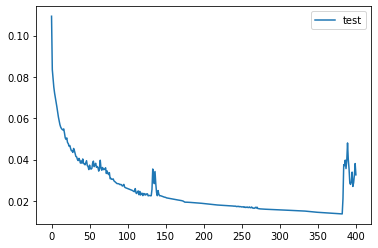

In [92]:
# network

# weights initialization
weights = "gaussian"

net = Network()
net.add(FCLayer(10, 20, weights))
net.add(ActivationLayer(sigmoid, sigmoid_prime))
net.add(FCLayer(20,10, weights))
net.add(ActivationLayer(sigmoid, sigmoid_prime))
net.add(FCLayer(10,1, weights))
net.add(ActivationLayer(sigmoid, sigmoid_prime))
# train
net.use(mse, mse_prime)
net.fit(dataClass.train_X.values.reshape(1168,1,10), dataClass.train_y.values.reshape(1168,1,1), epochs=500, learning_rate=0.4)

# test
# out = net.predict(x_train)
# print(out)

In [93]:
predicted = net.predict(dataClass.test_X.values.reshape(292,1,10))
predicted = [0 if x < 0.5 else 1 for x in predicted]
predicted;
actual = dataClass.test_y;

In [94]:
np.count_nonzero(np.array(predicted) == dataClass.test_y)/292

0.9006849315068494

In [95]:
accuracy = Accuracy(predicted, actual)
accuracy.accuracy()

0.9006849315068494

In [96]:
accuracy.F_score()
accuracy.fScore

0.9016949152542374

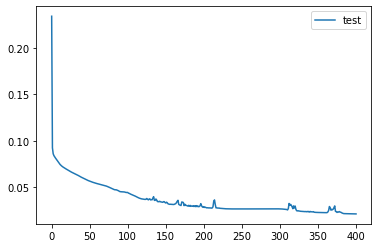

In [137]:
# network

# weights initialization
weights = "uniform"

net = Network()
net.add(FCLayer(10, 20, weights))
net.add(ActivationLayer(sigmoid, sigmoid_prime))
net.add(FCLayer(20,10, weights))
net.add(ActivationLayer(sigmoid, sigmoid_prime))
net.add(FCLayer(10,1, weights))
net.add(ActivationLayer(sigmoid, sigmoid_prime))
# train
net.use(mse, mse_prime)
net.fit(dataClass.train_X.values.reshape(1168,1,10), dataClass.train_y.values.reshape(1168,1,1), epochs=500, learning_rate=0.2)

# test
# out = net.predict(x_train)
# print(out)

In [138]:
predicted = net.predict(dataClass.test_X.values.reshape(292,1,10))
predicted = [0 if x < 0.5 else 1 for x in predicted]
predicted;
actual = dataClass.test_y;

In [139]:
np.count_nonzero(np.array(predicted) == dataClass.test_y)/292

0.8767123287671232

In [140]:
accuracy = Accuracy(predicted, actual)
accuracy.accuracy()

0.8767123287671232

In [141]:
accuracy.F_score()
accuracy.fScore

0.8783783783783783

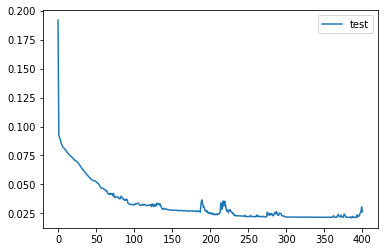

In [97]:
# network

# weights initialization
weights = "uniform"

net = Network()
net.add(FCLayer(10, 20, weights))
net.add(ActivationLayer(sigmoid, sigmoid_prime))
net.add(FCLayer(20,10, weights))
net.add(ActivationLayer(sigmoid, sigmoid_prime))
net.add(FCLayer(10,1, weights))
net.add(ActivationLayer(sigmoid, sigmoid_prime))
# train
net.use(mse, mse_prime)
net.fit(dataClass.train_X.values.reshape(1168,1,10), dataClass.train_y.values.reshape(1168,1,1), epochs=500, learning_rate=0.3)

# test
# out = net.predict(x_train)
# print(out)

In [98]:
predicted = net.predict(dataClass.test_X.values.reshape(292,1,10))
predicted = [0 if x < 0.5 else 1 for x in predicted]
predicted;
actual = dataClass.test_y;

In [99]:
np.count_nonzero(np.array(predicted) == dataClass.test_y)/292

0.8732876712328768

In [100]:
accuracy = Accuracy(predicted, actual)
accuracy.accuracy()

0.8732876712328768

In [101]:
accuracy.F_score()
accuracy.fScore

0.8762541806020068

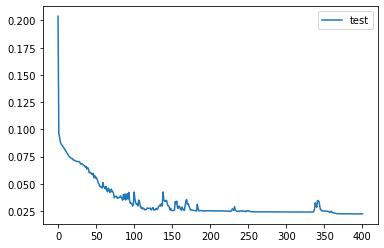

In [102]:
# network

# weights initialization
weights = "uniform"

net = Network()
net.add(FCLayer(10, 20, weights))
net.add(ActivationLayer(sigmoid, sigmoid_prime))
net.add(FCLayer(20,10, weights))
net.add(ActivationLayer(sigmoid, sigmoid_prime))
net.add(FCLayer(10,1, weights))
net.add(ActivationLayer(sigmoid, sigmoid_prime))
# train
net.use(mse, mse_prime)
net.fit(dataClass.train_X.values.reshape(1168,1,10), dataClass.train_y.values.reshape(1168,1,1), epochs=500, learning_rate=0.4)

# test
# out = net.predict(x_train)
# print(out)

In [103]:
predicted = net.predict(dataClass.test_X.values.reshape(292,1,10))
predicted = [0 if x < 0.5 else 1 for x in predicted]
predicted;
actual = dataClass.test_y;

In [104]:
np.count_nonzero(np.array(predicted) == dataClass.test_y)/292

0.8835616438356164

In [105]:
accuracy = Accuracy(predicted, actual)
accuracy.accuracy()

0.8835616438356164

In [106]:
accuracy.F_score()
accuracy.fScore

0.8851351351351352

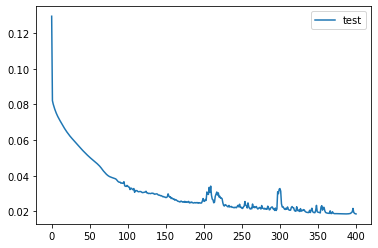

In [142]:
# network

# weights initialization
weights = "xavier"

net = Network()
net.add(FCLayer(10, 20, weights))
net.add(ActivationLayer(sigmoid, sigmoid_prime))
net.add(FCLayer(20,10, weights))
net.add(ActivationLayer(sigmoid, sigmoid_prime))
net.add(FCLayer(10,1, weights))
net.add(ActivationLayer(sigmoid, sigmoid_prime))
# train
net.use(mse, mse_prime)
net.fit(dataClass.train_X.values.reshape(1168,1,10), dataClass.train_y.values.reshape(1168,1,1), epochs=500, learning_rate=0.2)

# test
# out = net.predict(x_train)
# print(out)

In [143]:
predicted = net.predict(dataClass.test_X.values.reshape(292,1,10))
predicted = [0 if x < 0.5 else 1 for x in predicted]
predicted;
actual = dataClass.test_y;

In [144]:
np.count_nonzero(np.array(predicted) == dataClass.test_y)/292

0.8664383561643836

In [145]:
accuracy = Accuracy(predicted, actual)
accuracy.accuracy()

0.8664383561643836

In [146]:
accuracy.F_score()
accuracy.fScore

0.8704318936877077

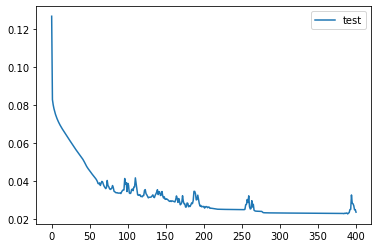

In [147]:
# network

# weights initialization
weights = "xavier"

net = Network()
net.add(FCLayer(10, 20, weights))
net.add(ActivationLayer(sigmoid, sigmoid_prime))
net.add(FCLayer(20,10, weights))
net.add(ActivationLayer(sigmoid, sigmoid_prime))
net.add(FCLayer(10,1, weights))
net.add(ActivationLayer(sigmoid, sigmoid_prime))
# train
net.use(mse, mse_prime)
net.fit(dataClass.train_X.values.reshape(1168,1,10), dataClass.train_y.values.reshape(1168,1,1), epochs=500, learning_rate=0.3)

# test
# out = net.predict(x_train)
# print(out)

In [148]:
predicted = net.predict(dataClass.test_X.values.reshape(292,1,10))
predicted = [0 if x < 0.5 else 1 for x in predicted]
predicted;
actual = dataClass.test_y;

In [149]:
np.count_nonzero(np.array(predicted) == dataClass.test_y)/292

0.8767123287671232

In [150]:
accuracy = Accuracy(predicted, actual)
accuracy.accuracy()

0.8767123287671232

In [151]:
accuracy.F_score()
accuracy.fScore

0.8775510204081632

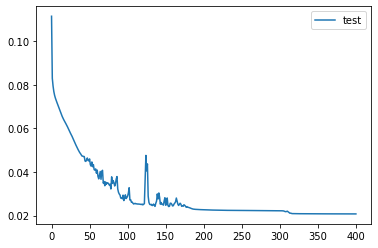

In [112]:
# network

# weights initialization
weights = "xavier"

net = Network()
net.add(FCLayer(10, 20, weights))
net.add(ActivationLayer(sigmoid, sigmoid_prime))
net.add(FCLayer(20,10, weights))
net.add(ActivationLayer(sigmoid, sigmoid_prime))
net.add(FCLayer(10,1, weights))
net.add(ActivationLayer(sigmoid, sigmoid_prime))
# train
net.use(mse, mse_prime)
net.fit(dataClass.train_X.values.reshape(1168,1,10), dataClass.train_y.values.reshape(1168,1,1), epochs=500, learning_rate=0.4)

# test
# out = net.predict(x_train)
# print(out)

In [113]:
predicted = net.predict(dataClass.test_X.values.reshape(292,1,10))
predicted = [0 if x < 0.5 else 1 for x in predicted]
predicted;
actual = dataClass.test_y;

In [114]:
np.count_nonzero(np.array(predicted) == dataClass.test_y)/292

0.8972602739726028

In [115]:
accuracy = Accuracy(predicted, actual)
accuracy.accuracy()

0.8972602739726028

In [116]:
accuracy.F_score()
accuracy.fScore

0.8986486486486487

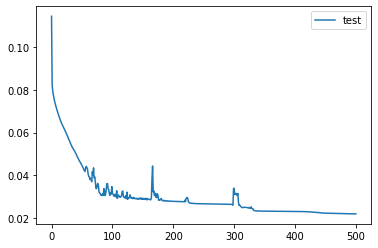

In [152]:
# network

# weights initialization
weights = "xavier"

net = Network()
net.add(FCLayer(10, 20, weights))
net.add(ActivationLayer(sigmoid, sigmoid_prime))
net.add(FCLayer(20,10, weights))
net.add(ActivationLayer(sigmoid, sigmoid_prime))
net.add(FCLayer(10,1, weights))
net.add(ActivationLayer(sigmoid, sigmoid_prime))
# train
net.use(mse, mse_prime)
net.fit(dataClass.train_X.values.reshape(1168,1,10), dataClass.train_y.values.reshape(1168,1,1), epochs=600, learning_rate=0.3)

# test
# out = net.predict(x_train)
# print(out)

In [153]:
predicted = net.predict(dataClass.test_X.values.reshape(292,1,10))
predicted = [0 if x < 0.5 else 1 for x in predicted]
predicted;
actual = dataClass.test_y;

In [154]:
np.count_nonzero(np.array(predicted) == dataClass.test_y)/292

0.8938356164383562

In [155]:
accuracy = Accuracy(predicted, actual)
accuracy.accuracy()

0.8938356164383562

In [156]:
accuracy.F_score()
accuracy.fScore

0.8927335640138409

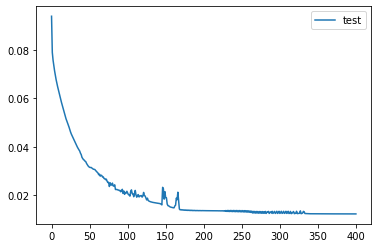

In [36]:
# network

# weights initialization
weights = "gaussian"

net = Network()
net.add(FCLayer(10, 30, weights))
net.add(ActivationLayer(sigmoid, sigmoid_prime))
net.add(FCLayer(30,15, weights))
net.add(ActivationLayer(sigmoid, sigmoid_prime))
net.add(FCLayer(15,1, weights))
net.add(ActivationLayer(sigmoid, sigmoid_prime))
# train
net.use(mse, mse_prime)
net.fit(dataClass.train_X.values.reshape(1168,1,10), dataClass.train_y.values.reshape(1168,1,1), epochs=500, learning_rate=0.3)

# test
# out = net.predict(x_train)
# print(out)

In [37]:
predicted = net.predict(dataClass.test_X.values.reshape(292,1,10))
predicted = [0 if x < 0.5 else 1 for x in predicted]
predicted;
actual = dataClass.test_y;

In [38]:
np.count_nonzero(np.array(predicted) == dataClass.test_y)/292

0.8904109589041096

In [39]:
accuracy = Accuracy(predicted, actual)
accuracy.accuracy()

0.8904109589041096

In [40]:
accuracy.F_score()
accuracy.fScore

0.8904109589041096

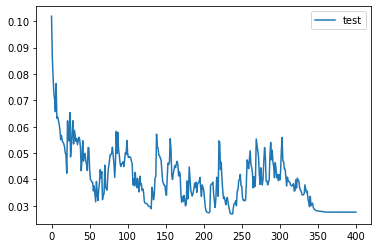

In [41]:
# network

# weights initialization
weights = "gaussian"

net = Network()
net.add(FCLayer(10, 30, weights))
net.add(ActivationLayer(tanh, tanh_prime))
net.add(FCLayer(30,15, weights))
net.add(ActivationLayer(tanh, tanh_prime))
net.add(FCLayer(15,1, weights))
net.add(ActivationLayer(sigmoid, sigmoid_prime))
# train
net.use(mse, mse_prime)
net.fit(dataClass.train_X.values.reshape(1168,1,10), dataClass.train_y.values.reshape(1168,1,1), epochs=500, learning_rate=0.3)

# test
# out = net.predict(x_train)
# print(out)

In [42]:
predicted = net.predict(dataClass.test_X.values.reshape(292,1,10))
predicted = [0 if x < 0.5 else 1 for x in predicted]
predicted;
actual = dataClass.test_y;

In [43]:
np.count_nonzero(np.array(predicted) == dataClass.test_y)/292

0.9143835616438356

In [44]:
accuracy = Accuracy(predicted, actual)
accuracy.accuracy()

0.9143835616438356

In [45]:
accuracy.F_score()
accuracy.fScore

0.9140893470790378

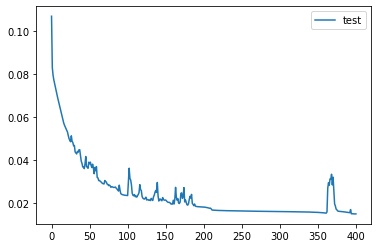

In [46]:
# network

# weights initialization
weights = "gaussian"

net = Network()
net.add(FCLayer(10, 30, weights))
net.add(ActivationLayer(sigmoid, sigmoid_prime))
net.add(FCLayer(30,20, weights))
net.add(ActivationLayer(sigmoid, sigmoid_prime))
net.add(FCLayer(20,10, weights))
net.add(ActivationLayer(sigmoid, sigmoid_prime))
net.add(FCLayer(10,1, weights))
net.add(ActivationLayer(sigmoid, sigmoid_prime))
# train
net.use(mse, mse_prime)
net.fit(dataClass.train_X.values.reshape(1168,1,10), dataClass.train_y.values.reshape(1168,1,1), epochs=500, learning_rate=0.3)

# test
# out = net.predict(x_train)
# print(out)

In [47]:
predicted = net.predict(dataClass.test_X.values.reshape(292,1,10))
predicted = [0 if x < 0.5 else 1 for x in predicted]
predicted;
actual = dataClass.test_y;

In [48]:
np.count_nonzero(np.array(predicted) == dataClass.test_y)/292

0.8904109589041096

In [49]:
accuracy = Accuracy(predicted, actual)
accuracy.accuracy()

0.8904109589041096

In [50]:
accuracy.F_score()
accuracy.fScore

0.891891891891892

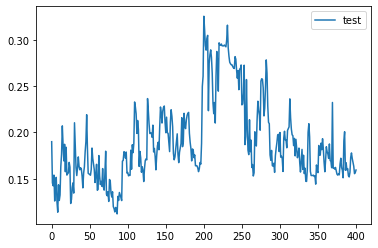

In [51]:
# network

# weights initialization
weights = "gaussian"

net = Network()
net.add(FCLayer(10, 20, weights))
net.add(ActivationLayer(tanh, tanh_prime))
net.add(FCLayer(20,30, weights))
net.add(ActivationLayer(tanh, tanh_prime))
net.add(FCLayer(30,50, weights))
net.add(ActivationLayer(tanh, tanh_prime))
net.add(FCLayer(50,40, weights))
net.add(ActivationLayer(tanh, tanh_prime))
net.add(FCLayer(40,30, weights))
net.add(ActivationLayer(tanh, tanh_prime))
net.add(FCLayer(30,1, weights))
net.add(ActivationLayer(sigmoid, sigmoid_prime))
# train
net.use(mse, mse_prime)
net.fit(dataClass.train_X.values.reshape(1168,1,10), dataClass.train_y.values.reshape(1168,1,1), epochs=500, learning_rate=0.3)

# test
# out = net.predict(x_train)
# print(out)

In [52]:
predicted = net.predict(dataClass.test_X.values.reshape(292,1,10))
predicted = [0 if x < 0.5 else 1 for x in predicted]
predicted;
actual = dataClass.test_y;

In [53]:
np.count_nonzero(np.array(predicted) == dataClass.test_y)/292

0.839041095890411

In [54]:
accuracy = Accuracy(predicted, actual)
accuracy.accuracy()

0.839041095890411

In [55]:
accuracy.F_score()
accuracy.fScore

0.8562691131498472

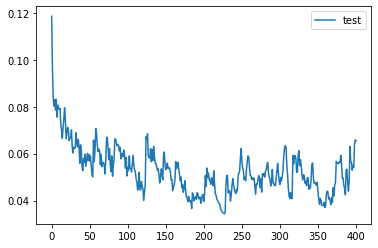

In [56]:
# network

# weights initialization
weights = "gaussian"

net = Network()
net.add(FCLayer(10, 30, weights))
net.add(ActivationLayer(tanh, tanh_prime))
net.add(FCLayer(30,20, weights))
net.add(ActivationLayer(tanh, tanh_prime))
net.add(FCLayer(20,10, weights))
net.add(ActivationLayer(tanh, tanh_prime))
net.add(FCLayer(10,1, weights))
net.add(ActivationLayer(sigmoid, sigmoid_prime))
# train
net.use(mse, mse_prime)
net.fit(dataClass.train_X.values.reshape(1168,1,10), dataClass.train_y.values.reshape(1168,1,1), epochs=500, learning_rate=0.3)

# test
# out = net.predict(x_train)
# print(out)

In [57]:
predicted = net.predict(dataClass.test_X.values.reshape(292,1,10))
predicted = [0 if x < 0.5 else 1 for x in predicted]
predicted;
actual = dataClass.test_y;

In [58]:
np.count_nonzero(np.array(predicted) == dataClass.test_y)/292

0.9075342465753424

In [59]:
accuracy = Accuracy(predicted, actual)
accuracy.accuracy()

0.9075342465753424

In [60]:
accuracy.F_score()
accuracy.fScore

0.9096989966555183

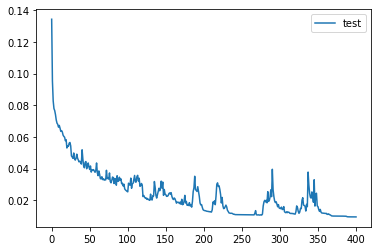

In [61]:
# network

# weights initialization
weights = "gaussian"

net = Network()
net.add(FCLayer(10, 20, weights))
net.add(ActivationLayer(sigmoid, sigmoid_prime))
net.add(FCLayer(20,30, weights))
net.add(ActivationLayer(sigmoid, sigmoid_prime))
net.add(FCLayer(30,50, weights))
net.add(ActivationLayer(sigmoid, sigmoid_prime))
net.add(FCLayer(50,40, weights))
net.add(ActivationLayer(sigmoid, sigmoid_prime))
net.add(FCLayer(40,30, weights))
net.add(ActivationLayer(sigmoid, sigmoid_prime))
net.add(FCLayer(30,1, weights))
net.add(ActivationLayer(sigmoid, sigmoid_prime))
# train
net.use(mse, mse_prime)
net.fit(dataClass.train_X.values.reshape(1168,1,10), dataClass.train_y.values.reshape(1168,1,1), epochs=500, learning_rate=0.3)

# test
# out = net.predict(x_train)
# print(out)

In [62]:
predicted = net.predict(dataClass.test_X.values.reshape(292,1,10))
predicted = [0 if x < 0.5 else 1 for x in predicted]
predicted;
actual = dataClass.test_y;

In [63]:
np.count_nonzero(np.array(predicted) == dataClass.test_y)/292

0.8904109589041096

In [64]:
accuracy = Accuracy(predicted, actual)
accuracy.accuracy()

0.8904109589041096

In [65]:
accuracy.F_score()
accuracy.fScore

0.8896551724137931